In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import os
from PIL import Image
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns

C:\Users\dli0305\miniconda3\envs\mypytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())

True


In [3]:
def load_data(data_dir):
    labels = os.listdir(data_dir)
    label_to_int = {i: label for i, label in enumerate(labels)}
    x_data = []
    y_data = []
    class_counts = np.zeros(len(labels))  # Track the count of each class
    for i, label in tqdm(enumerate(labels), desc='Reading images'):
        label_dir = os.path.join(data_dir, label)
        class_counts[i] = len(os.listdir(label_dir))  # Count of images in each class
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            image = Image.open(image_path)
            # Convert image to grayscale if it's not already
            if image.mode != 'L':
                image = image.convert('L')
            image = np.array(image)
            # Expand dimensions for compatibility with both grayscale and RGB images
            image = np.expand_dims(image, axis=-1 if image.ndim == 2 else -1)
            x_data.append(image)
            y_data.append(i)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    
    # Calculate class weights
    total_samples = sum(class_counts)
    class_weights = [total_samples / (len(labels) * count) for count in class_counts]
    
    return x_data, y_data, label_to_int, class_weights

train_dir = 'E:\\Face_expression_recognition_dataset48\\train'
test_dir = 'E:\\Face_expression_recognition_dataset48\\test'

x_train, y_train, label_to_int_train, class_weights_train = load_data(train_dir)
x_test, y_test, label_to_int_test, class_weights_test = load_data(test_dir)


Reading images: 7it [03:47, 32.44s/it]
Reading images: 7it [00:49,  7.13s/it]


In [4]:
label_to_int_train

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [5]:
num_classes = len(label_to_int_train)
print(num_classes)

7


In [6]:
x_train
y_train

array([0, 0, 0, ..., 6, 6, 6])

In [7]:
print(x_train.shape)
print(y_train.shape)

(28821, 48, 48, 1)
(28821,)


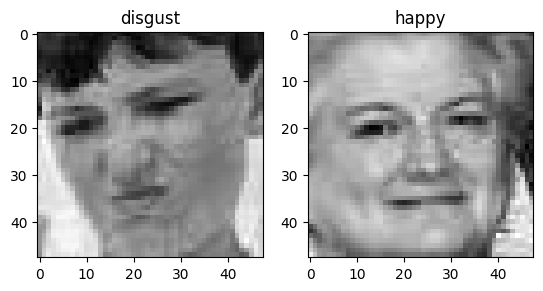

In [9]:
num = [0] * 7
for n in y_train:
    num[n] += 1

min_idx = np.argmin(num)
max_idx = np.argmax(num)

f, ax = plt.subplots(1, 2)
ax[0].imshow(x_train[np.where(y_train == min_idx)[0][0]], cmap='gray' if x_train.shape[-1] == 1 else None)
ax[0].set_title(label_to_int_train[min_idx])
ax[1].imshow(x_train[np.where(y_train == max_idx)[0][0]], cmap='gray' if x_train.shape[-1] == 1 else None)
ax[1].set_title(label_to_int_train[max_idx])

plt.show()

In [10]:
#TRAINING
x_train_tensor = torch.tensor(x_train).permute(0,3,1,2).cuda()
y_train_tensor = torch.tensor(y_train).cuda()

#VALIDATION
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2).cuda()
y_test_tensor = torch.tensor(y_test).cuda()

In [11]:
#TRAINING
dataset = TensorDataset(x_train_tensor,y_train_tensor)
loader = DataLoader(dataset,batch_size=32, shuffle=True)

#VALIDATION
val_dataset = TensorDataset(x_test_tensor , y_test_tensor)
val_loader = DataLoader(dataset,batch_size=32, shuffle=True)

In [12]:
class_weights_train

[1.031125898894494,
 9.443315858453474,
 1.0034817729187702,
 0.5747188322565207,
 0.8264322991340254,
 0.8337962159347335,
 1.2846445286382884]

In [26]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, kernel_size=3),
    torch.nn.BatchNorm2d(16),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(16, 32, kernel_size=3),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=3),
    torch.nn.Conv2d(32, 64, kernel_size=3),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(64, 128, kernel_size=3),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(128, 256, kernel_size=3),
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=3),
    torch.nn.Conv2d(256, 512, kernel_size=3, padding = 1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Flatten(),
    torch.nn.Linear(2048, 256),
    torch.nn.Linear(256, num_classes)
)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
loss_weights = torch.tensor(class_weights_train, dtype=torch.float).cuda()
val_loss_weights = torch.tensor(class_weights_train, dtype=torch.float).cuda()

optimizer = torch.optim.Adam(net.parameters())
loss_function = torch.nn.CrossEntropyLoss(weight=loss_weights)
val_loss_function = torch.nn.CrossEntropyLoss(weight=val_loss_weights)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epoch = 30
net.train()

for epoch in tqdm(range(num_epoch)):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).long().view(-1)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    ##VALIDATION
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).long().view(-1)
            outputs = net(inputs)
            loss = val_loss_function(outputs, labels)
    
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:06<00:00,  6.23s/it]


In [28]:
net.eval()
with torch.no_grad():
    out = net(x_test_tensor)

pred = torch.argmax(out, dim=1)
accuracy = torch.mean((pred == y_test_tensor).float())
print(accuracy)

tensor(0.5142, device='cuda:0')


Text(0.5, 1.0, 'neutral')

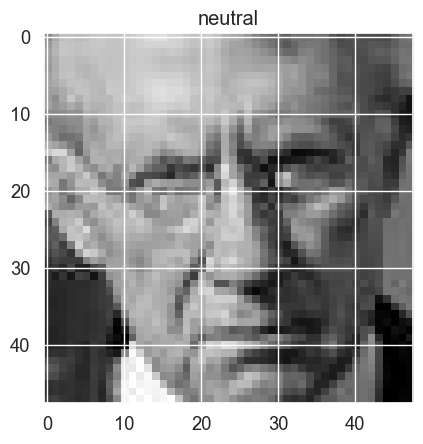

In [29]:
idx = np.random.choice(len(y_test))
plt.imshow(x_test[idx], cmap='gray' if x_train.shape[-1] == 1 else None)
plt.title(label_to_int_test[pred[idx].item()])

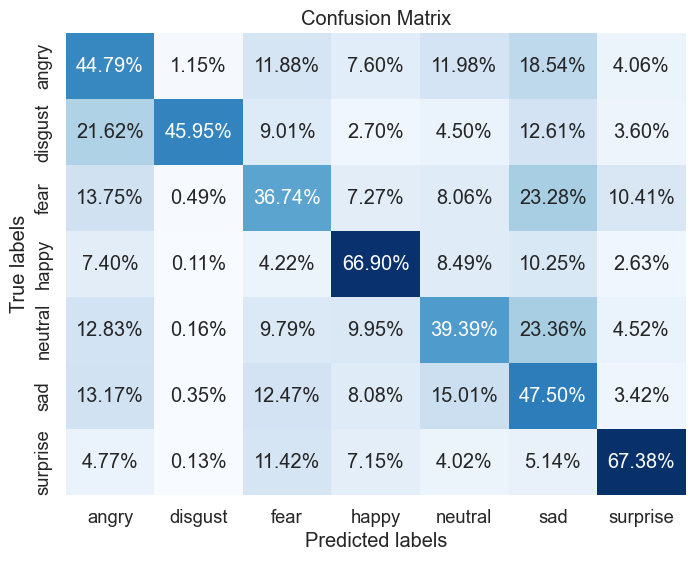

In [30]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, pred.cpu().numpy(), list(label_to_int_test.values()))

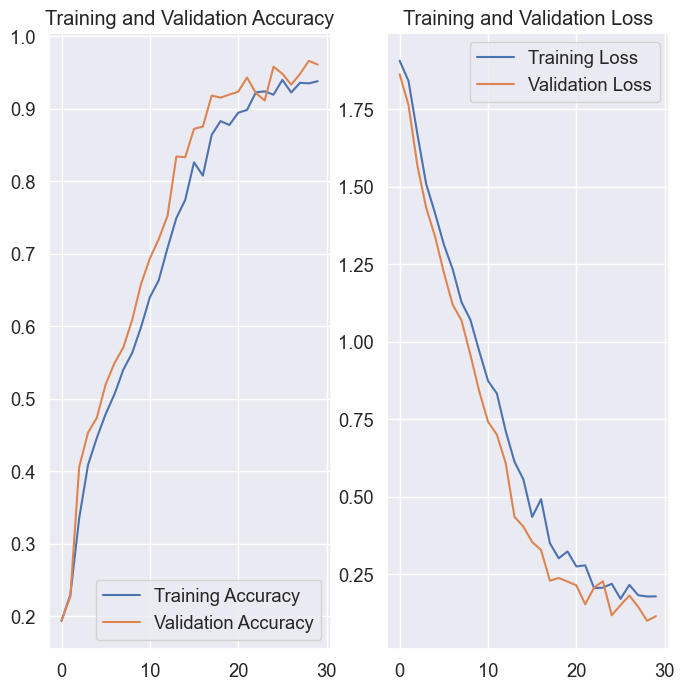

In [31]:
epochs_range = range(num_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accs, label='Training Accuracy')
plt.plot(epochs_range, val_accs, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()